In [1]:
import torch
import numpy as np
import pandas as pd

if torch.cuda.is_available():
    dev = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc.
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    dev = torch.device("cpu")
    print("Running on the CPU")

Running on the CPU


In [2]:
# Data was saved in the format training_target, training_input, test_target, test_input, cv_target, cv_input
# Since we only had 3 trajectories in the dataset, training, test and cv have the same values
# Input have the real data from the pedestrians dataset and target is input + random noise
[_, input_data, _, _, _, _] = torch.utils.data.DataLoader(torch.load("data_as_input_add_noise_for_target.pt"), pin_memory = False)
input_data = input_data.squeeze().to(dev)
input_data.shape

torch.Size([3, 7, 378])

#### Goal: Generate realistic s and r values for the synthetic data
    
#### Approach: 

* Get r and s values from pedestrian dataset;
* Cut into 100 size vectors;
* Add noise to those trajectories to make 1300 (1000 + 100 + 200);
* Use the values for x and y from KalmanNet in the synthetic data but replace the r and s for the new ones.

##### Get r and s values from pedestrian dataset;

In [3]:
# The previous data has being cut to have the same size as the smaller trajectorie.
# Read the dataset again to get the full trajectories.

df1 = pd.read_csv("pedestrians/crosswalk.csv")
df2 = pd.read_csv("pedestrians/fourway.csv")
df3 = pd.read_csv("pedestrians/night.csv")

print ("Lenght of trajectories: ", len(df1), ",", len(df2), "and", len(df3))

#I thinks it's ok to concatenate all to form a big trajectory since we are only interested on the s and r values of bb
df = pd.concat([df1, df2, df3], axis=0, ignore_index=True)

print ("Final lenght: ", len (df))
df.head(3)

Lenght of trajectories:  378 , 1281 and 565
Final lenght:  2224


,x,y,w,h
0,1074,499,37,75
1,1072,499,38,77
2,1068,497,41,82


In [4]:
def get_s_r(df):
    df['s'] =  df['w'] * df['h']    #scale is just area
    df['r'] = df['w'] / df['h']     # ratio
    df.drop(['w', 'h'], axis=1, inplace=True) #drop w and h columns as we won't need them
    return df

In [5]:
df = get_s_r(df)
df.head(3)

,x,y,s,r
0,1074,499,2775,0.493333
1,1072,499,2926,0.493506
2,1068,497,3362,0.500000


In [6]:
df.describe()

,x,y,s,r
count,2224.000000,2224.000000,2.224000e+03,2224.000000
mean,856.615108,463.024730,7.145170e+04,0.498115
std,450.406667,72.755723,3.966012e+05,0.002529
min,-165.000000,-375.000000,2.100000e+02,0.476190
25%,524.750000,457.750000,4.050000e+03,0.496774
50%,829.500000,482.000000,1.264100e+04,0.499444
75%,1196.250000,500.000000,4.503750e+04,0.500000
max,1811.000000,526.000000,1.261024e+07,0.500000


##### Cut into 100 size vectors

In [7]:
def get_tensor(df):
    df_matrix = df.to_numpy()
    df_matrix = df_matrix.transpose()  #kalmanNet shape is [state size, trajectory size]
    df_tensor = torch.from_numpy(df_matrix)  #get torch tensor
    #print (df_tensor.shape)
    return df_tensor

In [8]:
final_tensor = []

i = 0
while i < len (df):
    if len (df) - i < 100:
        break
    aux = get_tensor(df[i:i+100]) # transform pd into tensor
    final_tensor.append(aux)
    i+=100

final = torch.stack(final_tensor)
print (final.shape)

torch.Size([22, 4, 100])


##### Add noise to those trajectories to make 1300 (1000 + 100 + 200)

S: integer from 2.100000e+02 to 1.261024e+07

R: float from 0.476190 to 0.500000

In [9]:
final_tensor_input = []

for i in range(0, 1400//22):
        
    # Noise vector with integer numbers from a normal distribuition for S
    noise_s = torch.round(torch.empty([22,1,100]).normal_(mean=2,std=2)) 
    # Add noise to initial values
    final_s = torch.add(final[:,2:3,:], noise_s)
    # Replace values by new ones
    final[:,2:3,:] = final_s
    
    # Noise vector with small floating numbers from a normal distribuition  for R
    noise_r = torch.empty([22,1,100]).normal_(mean=0,std=0.02)
    # Add noise to initial values
    final_r = torch.add(final[:,3:4,:], noise_r)
    # Replace values by new ones
    final[:,3:4,:] = final_r
    
    final_tensor_input.append(final)


final_input = torch.concat(final_tensor_input, dim=0)
final_input = final_input[:1300,:,:]
print (final_input.shape)

torch.Size([1300, 4, 100])


In [10]:
final_tensor_target = []

for i in range(0, 1400//22):
        
    # Noise vector with integer numbers from a normal distribuition for S
    noise_s = torch.round(torch.empty([22,1,100]).normal_(mean=2,std=2)) 
    # Add noise to initial values
    final_s = torch.add(final[:,2:3,:], noise_s)
    # Replace values by new ones
    final[:,2:3,:] = final_s
    
    # Noise vector with small floating numbers from a normal distribuition  for R
    noise_r = torch.empty([22,1,100]).normal_(mean=0,std=0.02)
    # Add noise to initial values
    final_r = torch.add(final[:,3:4,:], noise_r)
    # Replace values by new ones
    final[:,3:4,:] = final_r
    
    final_tensor_target.append(final)


final_target = torch.concat(final_tensor_target, dim=0)
final_target = final_target[:1300,:,:]
print (final_target.shape)

torch.Size([1300, 4, 100])


In [11]:
# Split data in train, test and input
train_final_target, cv_final_target, test_final_target = torch.split(final_target, [1000,100,200])
train_final_input, cv_final_input, test_final_input = torch.split(final_target, [1000,100,200])

##### Use the values for x and y from KalmanNet in the synthetic data but replace the r and s for the new ones.

In [12]:
path = "KalmanNet-Dataset/Simulations/Linear_canonical/"
filename = "7x7_rq020_T100_mean_0_vdb_20_changed_x_y_distrib.pt"

[train_input, train_target, cv_input, cv_target, test_input, test_target] = torch.utils.data.DataLoader(torch.load(path+filename), pin_memory = False)

train_input = train_input.squeeze().to(dev)
train_target = train_target.squeeze().to(dev)
cv_input = cv_input.squeeze().to(dev)
cv_target = cv_target.squeeze().to(dev)
test_input = test_input.squeeze().to(dev)
test_target = test_target.squeeze().to(dev)

In [13]:
train_input[:, 2:4, :] = train_final_input[:, 2:4, :]
train_target[:, 2:4, :] = train_final_target[:, 2:4, :]
cv_input[:, 2:4, :] = cv_final_input[:, 2:4, :]
cv_target[:, 2:4, :] = cv_final_target[:, 2:4, :]
test_input[:, 2:4, :] = test_final_input[:, 2:4, :]
test_target[:, 2:4, :] = test_final_target[:, 2:4, :]

In [14]:
torch.save([train_input.type(torch.float32), train_target.type(torch.float32), 
            cv_input.type(torch.float32), cv_target.type(torch.float32), 
            test_input.type(torch.float32), test_target.type(torch.float32)], "synthetic_bb.pt")

<ipython-input-15-3753e4de42ed>:5: RuntimeWarning: invalid value encountered in sqrt
  w = np.sqrt(train_input[trajectory][3]*train_input[trajectory][2])


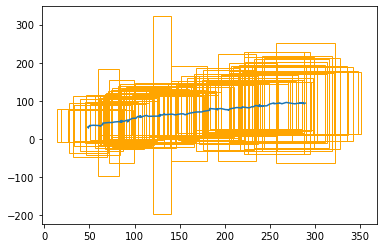

In [15]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

trajectory = 200
w = np.sqrt(train_input[trajectory][3]*train_input[trajectory][2])
h = train_input[trajectory][2]/w
x_bottom_left = train_input[trajectory][0] - w/2
y_bottom_left = train_input[trajectory][1] - h/2

fig, ax = plt.subplots()
ax.plot(train_input[trajectory][0], train_input[trajectory][1], label = "input", linestyle="-")

for i in range(0, train_input.shape[2]):
    step = i
    ax.add_patch(Rectangle((x_bottom_left[step], y_bottom_left[step]), w[step], h[step],color="orange", fill=False))

plt.show()